# Single-cell Deconvolution Model
## **Muhammad Ali**
*Department of Biology, New York University, 2025*

This model is a proof-of-concept of using a multi-layered perceptron to deconvolute cell types from single-cell RNA-seq data. 

**Data**: The data used in this notebook can be found in "data.zip" file. Extract the file in the directory of the Jupyter Notebook or adjust directories accordingly.

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchmetrics.classification import MulticlassAUROC, MulticlassROC
import seaborn as sns
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt

In [ ]:
Y_feature = "CellType"

BM3_training_metadata = pd.read_csv('GSM3587999_BM3.anno.txt', sep='\t')
BM4_training_metadata = pd.read_csv('GSM3588001_BM4.anno.txt', sep='\t')


BM3_training_counts = pd.read_csv('GSM3587998_BM3.dem.txt', sep='\t').transpose()
BM3_training_counts.columns = BM3_training_counts.iloc[0]
BM3_training_counts = BM3_training_counts.drop(BM3_training_counts.index[0])
BM3_training_counts.index = BM3_training_counts.index.astype(str)
BM3_training_metadata["Cell"] = BM3_training_metadata["Cell"].astype(str)
BM3_training_counts = BM3_training_counts.loc[BM3_training_metadata["Cell"]]

BM4_training_counts = pd.read_csv('GSM3588000_BM4.dem.txt', sep='\t').transpose()
BM4_training_counts.columns = BM4_training_counts.iloc[0]
BM4_training_counts = BM4_training_counts.drop(BM4_training_counts.index[0])
BM4_training_counts.index = BM4_training_counts.index.astype(str)
BM4_training_metadata["Cell"] = BM4_training_metadata["Cell"].astype(str)
BM4_training_counts = BM4_training_counts.loc[BM4_training_metadata["Cell"]]



BM3_training_features = pd.Categorical(BM3_training_metadata[Y_feature], 
                                       categories=BM3_training_metadata[Y_feature].unique(), ordered=False)


BM4_training_features = pd.Categorical(BM4_training_metadata[Y_feature], 
                                       categories=BM4_training_metadata[Y_feature].unique(), ordered=False)

In [3]:
encoder = LabelEncoder()

BM3_training_features_encoded = encoder.fit_transform(BM3_training_features)
BM4_training_features_encoded = encoder.fit_transform(BM4_training_features)

y_data_frame_training = torch.tensor(BM4_training_features_encoded, dtype=torch.long)
y_data_frame_training = y_data_frame_training - y_data_frame_training.min()

y_data_frame_test = torch.tensor(BM3_training_features_encoded, dtype=torch.long)
y_data_frame_test = y_data_frame_test - y_data_frame_test.min()

In [4]:
BM3_training_counts_clean = BM3_training_counts.apply(pd.to_numeric, errors='coerce').fillna(0)
BM4_training_counts_clean = BM4_training_counts.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert to PyTorch tensors
x_data_frame_training = torch.tensor(BM4_training_counts_clean.values, dtype=torch.float32)
x_data_frame_testing = torch.tensor(BM3_training_counts_clean.values, dtype=torch.float32)

In [5]:
print("Unique Cell Types for training:", torch.unique(y_data_frame_training))
print("Unique Cell Types for testing:", torch.unique(y_data_frame_test))

print("\nTrain class distribution:", torch.bincount(y_data_frame_training))

print("\nTest class distribution:", torch.bincount(y_data_frame_test))


print("\nTraining data shape: ", x_data_frame_training.shape,
        "\nTraining labels shape: ", y_data_frame_training.shape,
        "\n"
      "\nTest data shape: ", x_data_frame_testing.shape,
      "\nTest labels shape: ", y_data_frame_test.shape) 

Unique Cell Types for training: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
Unique Cell Types for testing: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Train class distribution: tensor([ 95, 215, 351,  15, 395, 143,  54,  97, 505, 424, 605, 216, 411, 160,
         52])

Test class distribution: tensor([16, 38, 49, 13, 87, 13,  5,  3, 83, 33, 88, 46, 84, 63, 22])

Training data shape:  torch.Size([3738, 27899]) 
Training labels shape:  torch.Size([3738]) 

Test data shape:  torch.Size([643, 27899]) 
Test labels shape:  torch.Size([643])


## Preparing Datasets

In [11]:
class CBISDataset(Dataset):
    
    def __init__(self, X, Y):
        super().__init__() 
        self.X = X
        self.Y = Y
        self.n_samples = X.shape[0]

   # Complete the class
    def __getitem__(self, index):
        return self.X[index], self.Y[index] 
    
    def __len__(self):
        return self.n_samples 
    
    def shape(self):
        return self.X.shape, self.Y.shape

In [12]:
train_dataset = CBISDataset(x_data_frame_training, y_data_frame_training)
test_dataset = CBISDataset(x_data_frame_testing, y_data_frame_test)

print("Train dataset shape: \n", 
      "X shape: ", (train_dataset).shape()[0],
      "\n Y shape: ", (train_dataset).shape()[1])

print("\n Test dataset shape: \n", 
      "X shape: ", (test_dataset).shape()[0],
      "\n Y shape: ", (test_dataset).shape()[1])

Train dataset shape: 
 X shape:  torch.Size([3738, 27899]) 
 Y shape:  torch.Size([3738])

 Test dataset shape: 
 X shape:  torch.Size([643, 27899]) 
 Y shape:  torch.Size([643])


## MLP Architecture 

In [13]:
import torch.nn as nn

class Manually_Designed_Network(nn.Module):
    def __init__(self):
        super(Manually_Designed_Network, self).__init__()
        # Define layers
        self.nn_layer_1 = nn.Linear(in_features=(train_dataset).shape()[0][1], 
                                    out_features=120)  
        
        self.relu_function = nn.ReLU()

        self.nn_layer_2 = nn.Linear(in_features=120, 
                                    out_features=(len(y_data_frame_training.unique())))  

    def forward(self, x):
        # Define the forward pass
        x_1 = self.nn_layer_1 (x)
        x_relu = self.relu_function(x_1)
        y_pred = self.nn_layer_2(x_relu)
        return y_pred

# Example of how to initialize the network
manually_designed_model = Manually_Designed_Network()

manually_designed_model

Manually_Designed_Network(
  (nn_layer_1): Linear(in_features=27899, out_features=120, bias=True)
  (relu_function): ReLU()
  (nn_layer_2): Linear(in_features=120, out_features=15, bias=True)
)

## Model Training

In [35]:
def model_training(model, train_loader, criterion, learning_rate, epochs):

    losses = []

    optimizer = optim.SGD(model.parameters(), 
                          lr=learning_rate) #Learning rate, 
    
    # Return average loss for the epoch
    for i in range(epochs):

        loss_per_batch = 0
        
        for x, y in train_loader:
            
            y_pred = model(x) #Forward pass

            loss = criterion(y_pred, y) #Read more about squeeze

            loss.backward() #Backward pass

            optimizer.step() #Update the weights

            optimizer.zero_grad() #Reseting the weights to 0

            loss_per_batch = loss_per_batch + loss.item()

        losses.append(loss_per_batch/len(train_loader))

        if not i % (epochs/10):
            print(f"Average training loss for epoch {i}: {loss.item()}")
    

    return losses        

#---------------------------------

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [36]:
# Complete code here
BATCH_SIZE = 100
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle= True)
#---------------------------------
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([100, 27899])
Labels batch shape: torch.Size([100])
Feature batch shape: torch.Size([100, 27899])
Labels batch shape: torch.Size([100])


Average training loss for epoch 0: 2.709747552871704
Average training loss for epoch 10: 0.7195668816566467
Average training loss for epoch 20: 0.5130892992019653
Average training loss for epoch 30: 0.2752600610256195
Average training loss for epoch 40: 0.21394842863082886
Average training loss for epoch 50: 0.16398365795612335
Average training loss for epoch 60: 0.17714379727840424
Average training loss for epoch 70: 0.21493883430957794
Average training loss for epoch 80: 0.12826453149318695
Average training loss for epoch 90: 0.2533086836338043


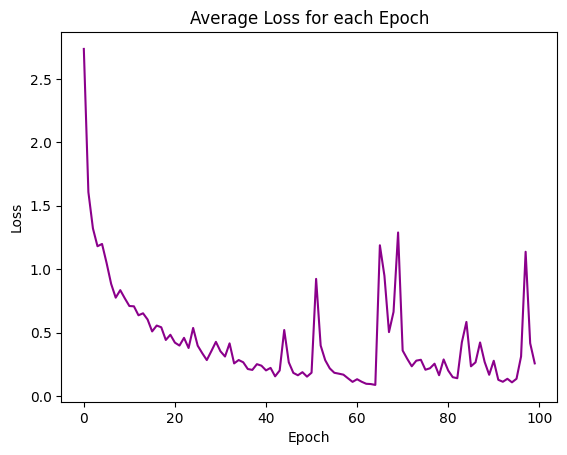

In [37]:
epochs_for_nn = 100
learning_rate_for_nn = 0.01

reset_weights(manually_designed_model)

average_losses = model_training(model = manually_designed_model, 
               train_loader = train_dataloader, 
               criterion = torch.nn.CrossEntropyLoss(), 
               learning_rate = learning_rate_for_nn, 
               epochs = epochs_for_nn)

# Create figure and axis for better visualization
plt.plot(range(epochs_for_nn), 
         average_losses, 
         color='darkmagenta')

# Adding labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Average Loss for each Epoch")

# Display the plot
plt.show()

## MLP Testing

In [38]:
def model_testing(model, test_loader, criterion,):

    losses = []
    correct = []
    index = 0
    predictions = []
    true_y = []
    probabilities = []  #We will use this for ROC curve
    average_loss_printed = 0

    
    model.eval()  # Set the model to evaluation mode -- Read more about this

    with torch.no_grad():

        for x, y in test_loader:
            
            y_pred = model(x) #Forward pass

            y_pred_probs = torch.softmax(y_pred, dim=1)

            probabilities.append(y_pred_probs)

            loss = criterion(y_pred.squeeze(), y) #Read more about squeeze

            losses.append([loss.item(), index])

            preds = torch.argmax(y_pred, dim=1)

            predictions.append(preds)

            true_y.append(y)
            
            correct_preds = (preds == y).sum().item()

            correct.append([correct_preds, index])
            
            index = index + 1

            print("Batch:", index, "Loss:", loss.item(), "Correct:", correct_preds, "Wrong:", len(y)-(correct_preds))

            average_loss_printed += loss.item()

    print("Average loss for the test set:", average_loss_printed/len(test_loader))

    probabilities = torch.cat(probabilities)

    predictions = torch.cat(predictions)

    true_y = torch.cat(true_y)

    return predictions, true_y, probabilities

In [39]:
testing_data_predictions = model_testing(model = manually_designed_model, 
                                         test_loader = test_dataloader, 
                                         criterion = torch.nn.CrossEntropyLoss())

Batch: 1 Loss: 0.6942470073699951 Correct: 81 Wrong: 19
Batch: 2 Loss: 0.8731852769851685 Correct: 72 Wrong: 28
Batch: 3 Loss: 0.8329542279243469 Correct: 70 Wrong: 30
Batch: 4 Loss: 0.5589871406555176 Correct: 83 Wrong: 17
Batch: 5 Loss: 0.8124683499336243 Correct: 78 Wrong: 22
Batch: 6 Loss: 0.8175198435783386 Correct: 70 Wrong: 30
Batch: 7 Loss: 0.5905424356460571 Correct: 37 Wrong: 6
Average loss for the test set: 0.7399863260132926


## AUROC 

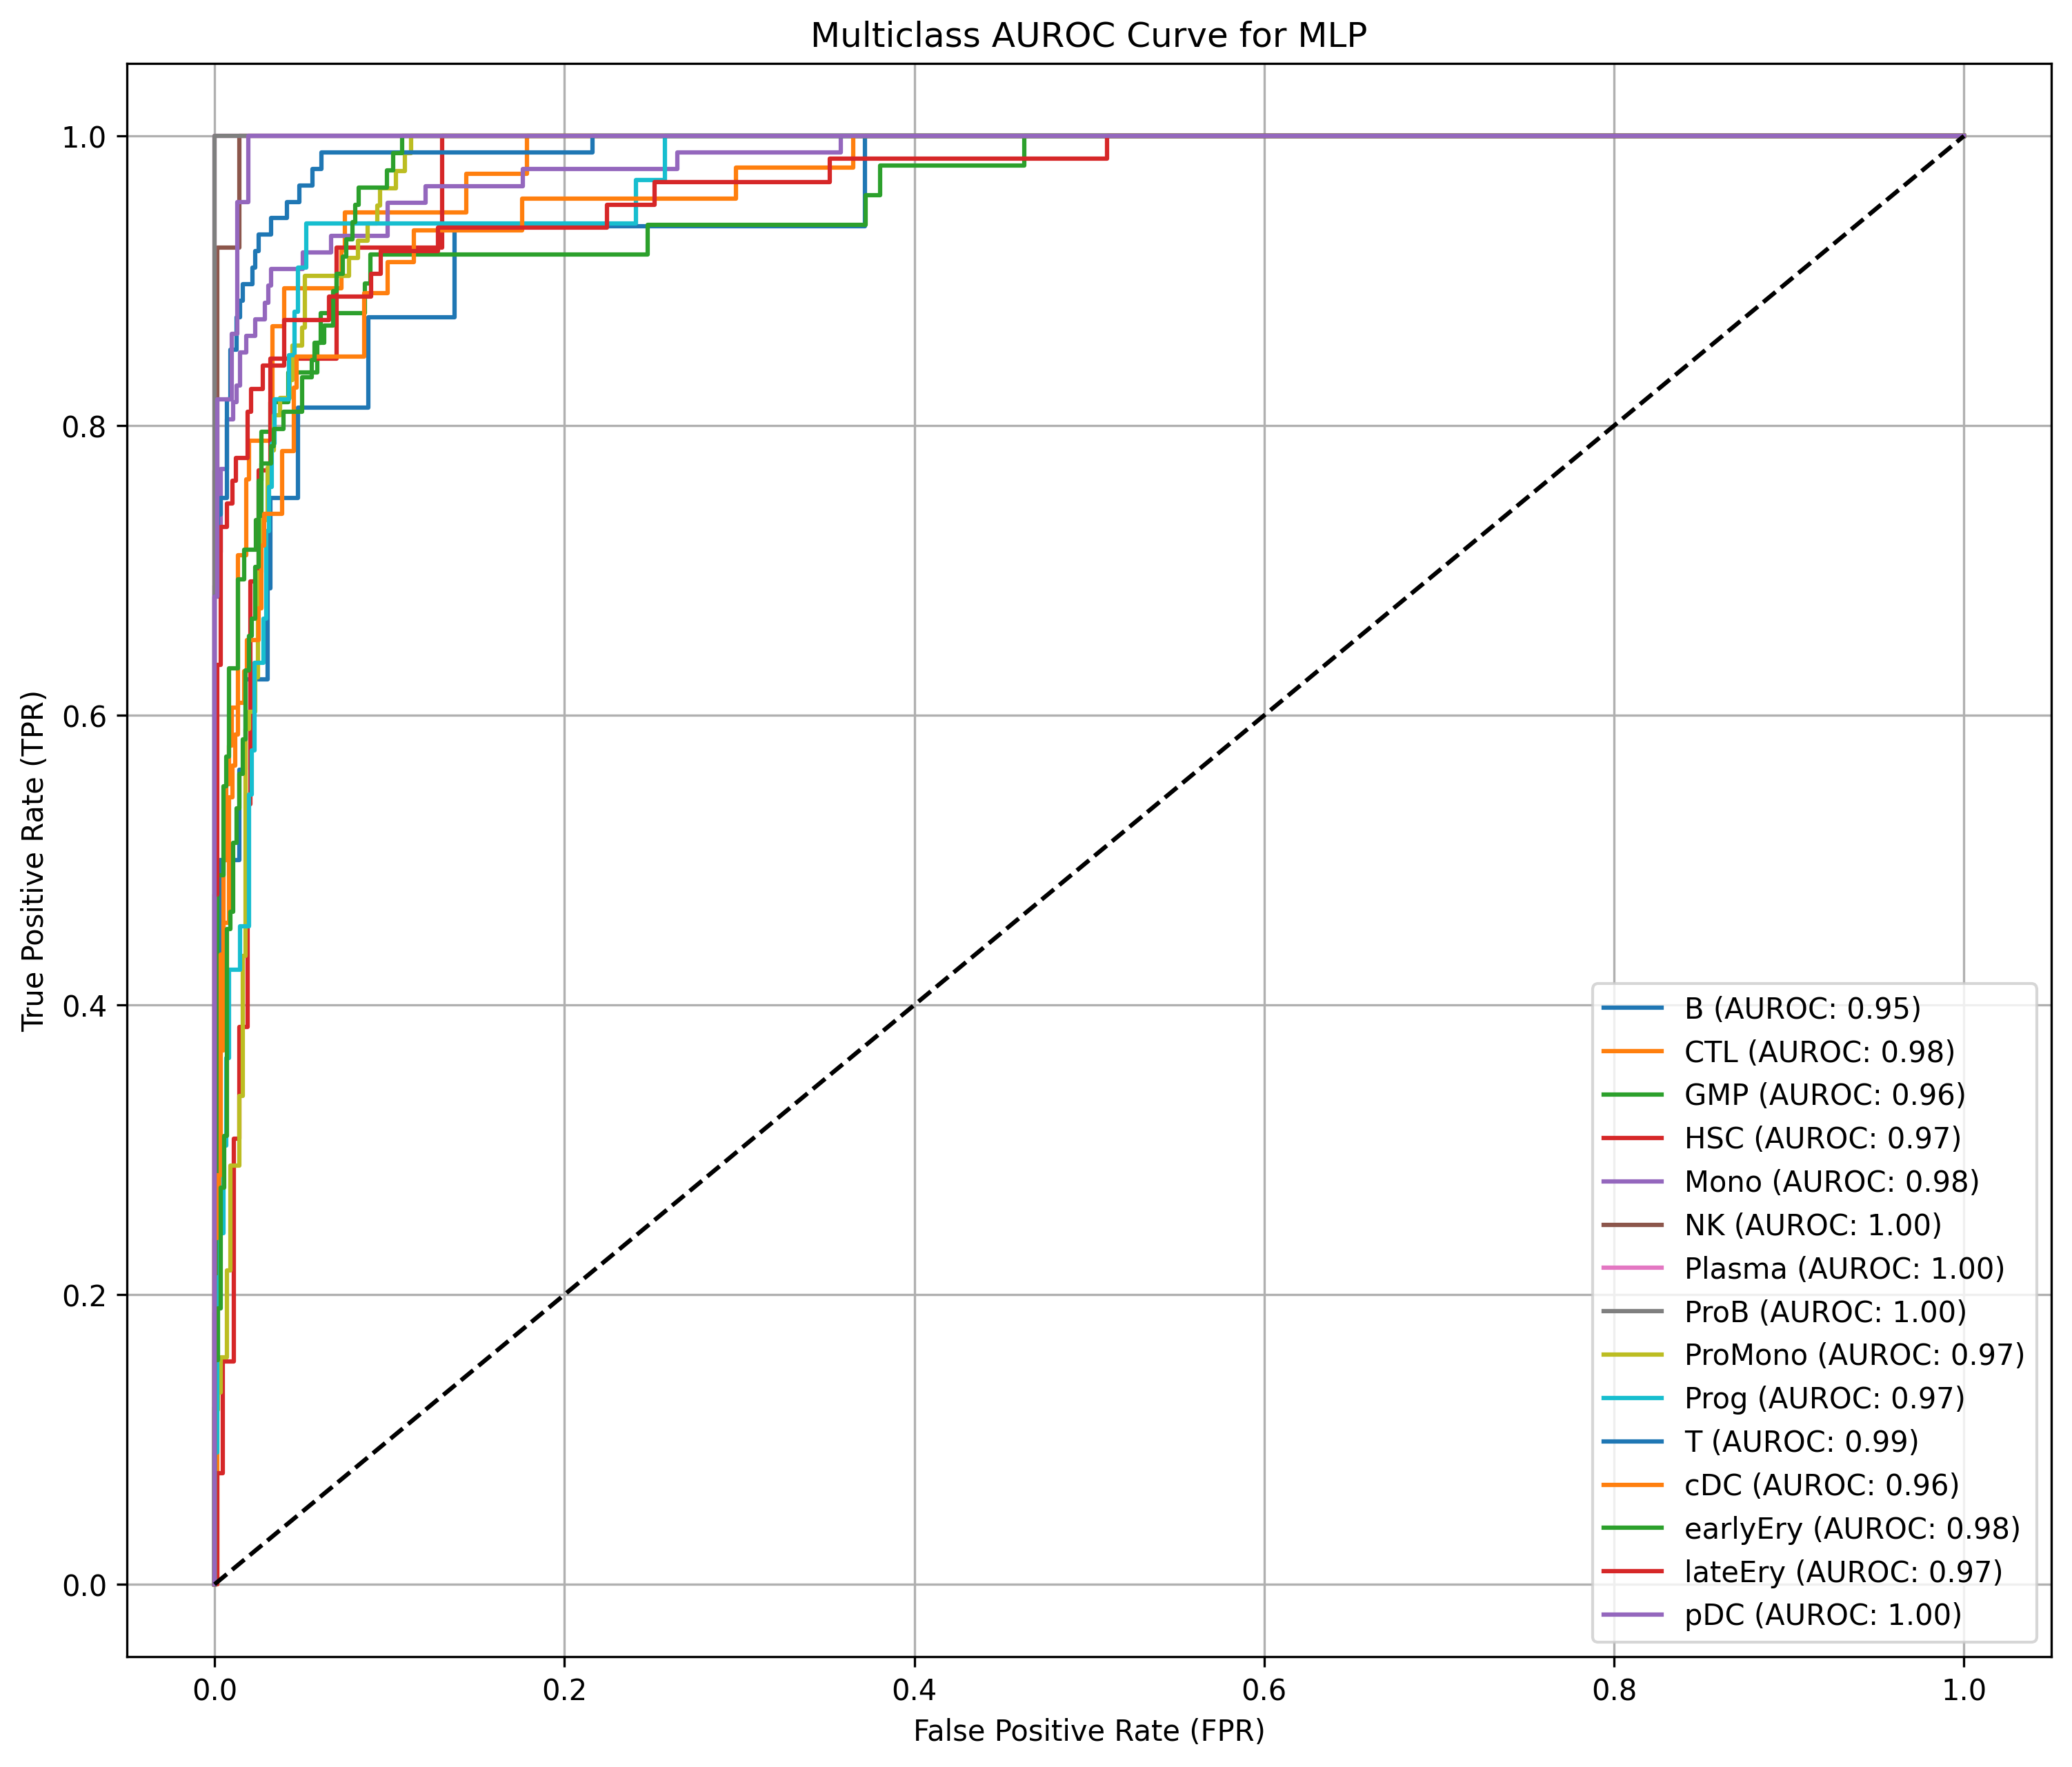

In [40]:
# Assuming 'encoder' was used earlier to encode the labels
class_names = encoder.classes_  # Get the original class names

num_classes = len(class_names)  # Ensure consistency
roc_metric = MulticlassROC(num_classes=num_classes, average=None)
auroc_metric = MulticlassAUROC(num_classes=num_classes, average=None)

# Compute ROC curve and AUROC
fpr, tpr, thresholds = roc_metric(testing_data_predictions[2],
                                  testing_data_predictions[1])

auroc = auroc_metric(testing_data_predictions[2],
                     testing_data_predictions[1])

plt.figure(figsize=(12, 10), dpi=300)

# Plotting the ROC curves with decoded labels
for i in range(num_classes):
    class_label = class_names[i]  # Decode class index
    plt.plot(fpr[i], tpr[i], label=f'{class_label} (AUROC: {auroc[i].item():.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multiclass AUROC Curve for MLP')
plt.legend()
plt.grid()
plt.show()

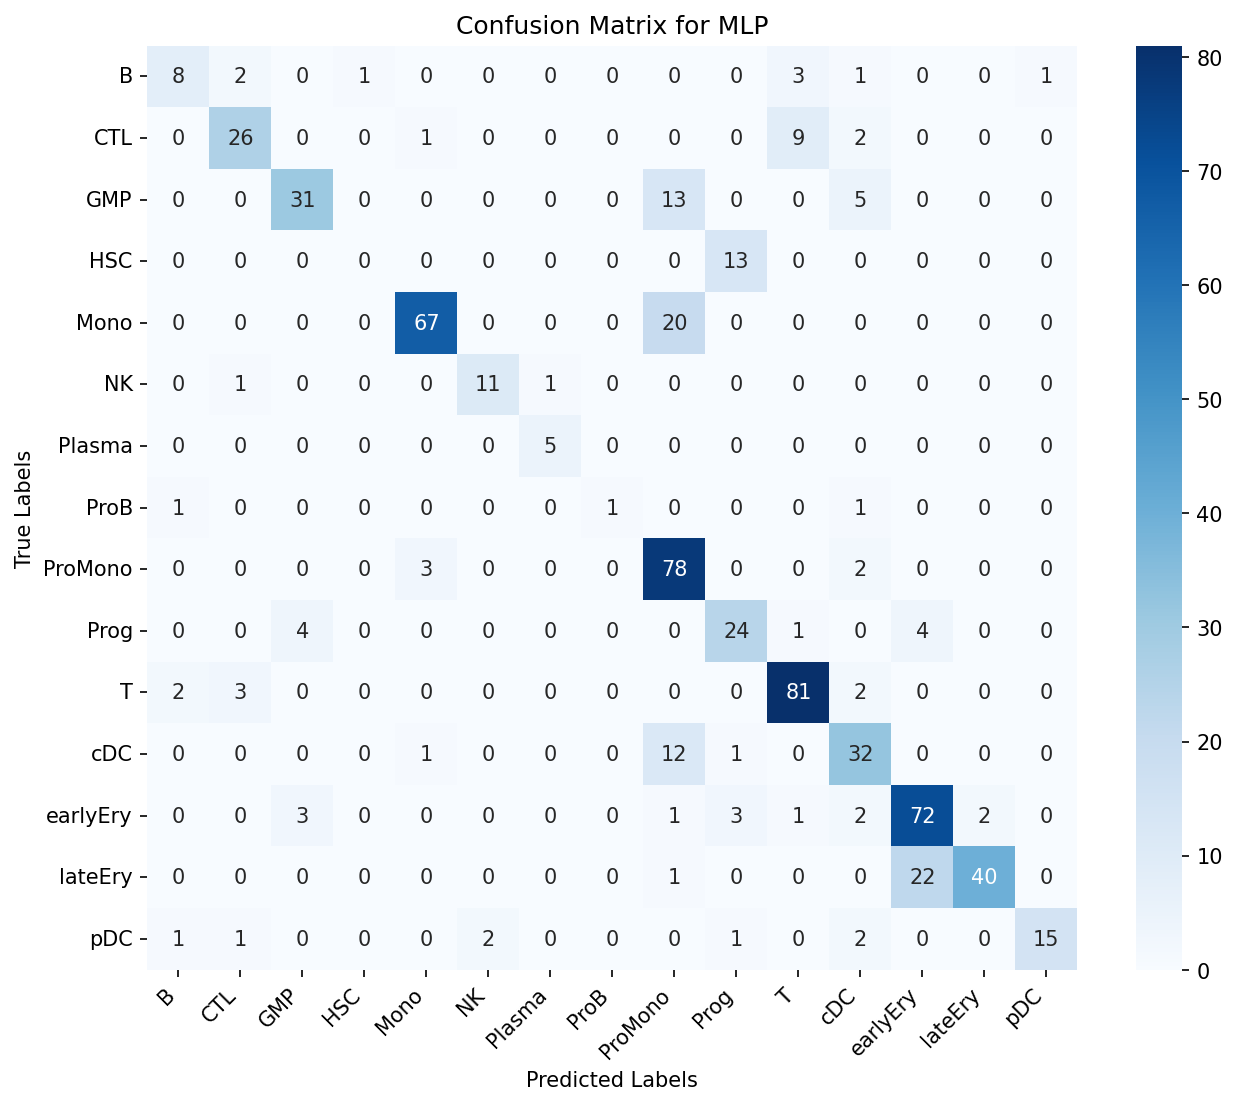

In [41]:
# Assuming 'encoder' was used earlier to encode the labels
class_names = encoder.classes_  # Get the original class names

num_classes = len(class_names)
confmat_metric = MulticlassConfusionMatrix(num_classes=num_classes)

# Compute the confusion matrix
conf_matrix = confmat_metric(testing_data_predictions[2], testing_data_predictions[1])

# Convert tensor to numpy for plotting
conf_matrix = conf_matrix.cpu().numpy()

# Plot confusion matrix
plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP')
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.yticks(rotation=0)
plt.show()